In [1]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [2]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [3]:
import gensim
print(gensim.__version__) # 3.7.1

3.7.1


In [ ]:
from typing import Any, Callable, Dict, Iterable, List, Tuple, Optional, Union
import pandas as pd
import numpy as np
import os
import dgl
import yaml

from rdkit import Chem
from mordred import Calculator, descriptors

from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

from mol2vec.features import MolSentence, DfVec, sentences2vec, mol2alt_sentence, mol2sentence
from gensim.models import word2vec

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV, LassoCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import torch

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

In [1]:
from utils import PreprocessSMILES
from utils import SimpleRegressions
from utils import SmallNN
from utils import LSTMRegressor


directory = './materials/'
preprocessor = PreprocessSMILES(directory)
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf)
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner')
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
mdf['graphs'] = preprocessor.generate_graphs(mdf)
# graph_df = mdf.copy()
# graph_df.drop(columns=['oil_property_param_title', 'oil_property_param_value', 'mol'], inplace=True)

X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.bias', 'norm_mean', 'regression.out_proj.bias', 'regression.dense.weight', 'regression.out_proj.weight', 'norm_std']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

In [4]:
batched_graph = dgl.batch(mdf['graphs'].tolist())
batched_graph

Graph(num_nodes=12584, num_edges=22700,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

In [5]:
print(y.shape)
print(X.shape)

(338,)
(338, 384)


Catboost
0:	learn: 0.9692396	test: 0.9939376	best: 0.9939376 (0)	total: 59.7ms	remaining: 59.6s
1:	learn: 0.9403343	test: 0.9670901	best: 0.9670901 (1)	total: 77ms	remaining: 38.4s
2:	learn: 0.9130635	test: 0.9402833	best: 0.9402833 (2)	total: 94.9ms	remaining: 31.5s
3:	learn: 0.8867780	test: 0.9121772	best: 0.9121772 (3)	total: 114ms	remaining: 28.5s
4:	learn: 0.8673071	test: 0.9014582	best: 0.9014582 (4)	total: 131ms	remaining: 26.1s
5:	learn: 0.8485032	test: 0.8859981	best: 0.8859981 (5)	total: 145ms	remaining: 24.1s
6:	learn: 0.8292037	test: 0.8727649	best: 0.8727649 (6)	total: 157ms	remaining: 22.3s
7:	learn: 0.8126213	test: 0.8531394	best: 0.8531394 (7)	total: 169ms	remaining: 21s
8:	learn: 0.7949081	test: 0.8373533	best: 0.8373533 (8)	total: 184ms	remaining: 20.2s
9:	learn: 0.7780011	test: 0.8172929	best: 0.8172929 (9)	total: 202ms	remaining: 20s
10:	learn: 0.7609658	test: 0.8033992	best: 0.8033992 (10)	total: 218ms	remaining: 19.6s
11:	learn: 0.7534297	test: 0.7982875	best: 0.7

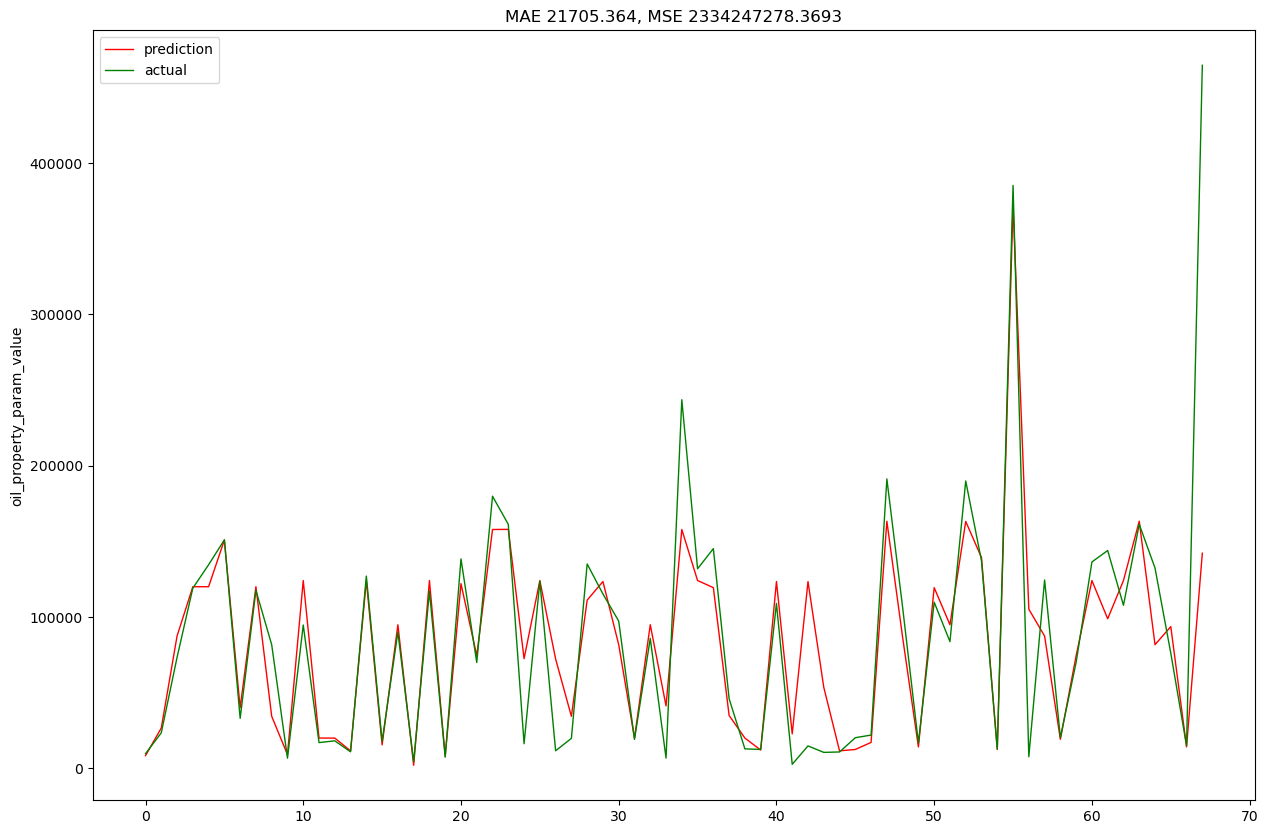

MAE score: 21705.364
MSE score: 2334247278.3693
RandomForestRegressor


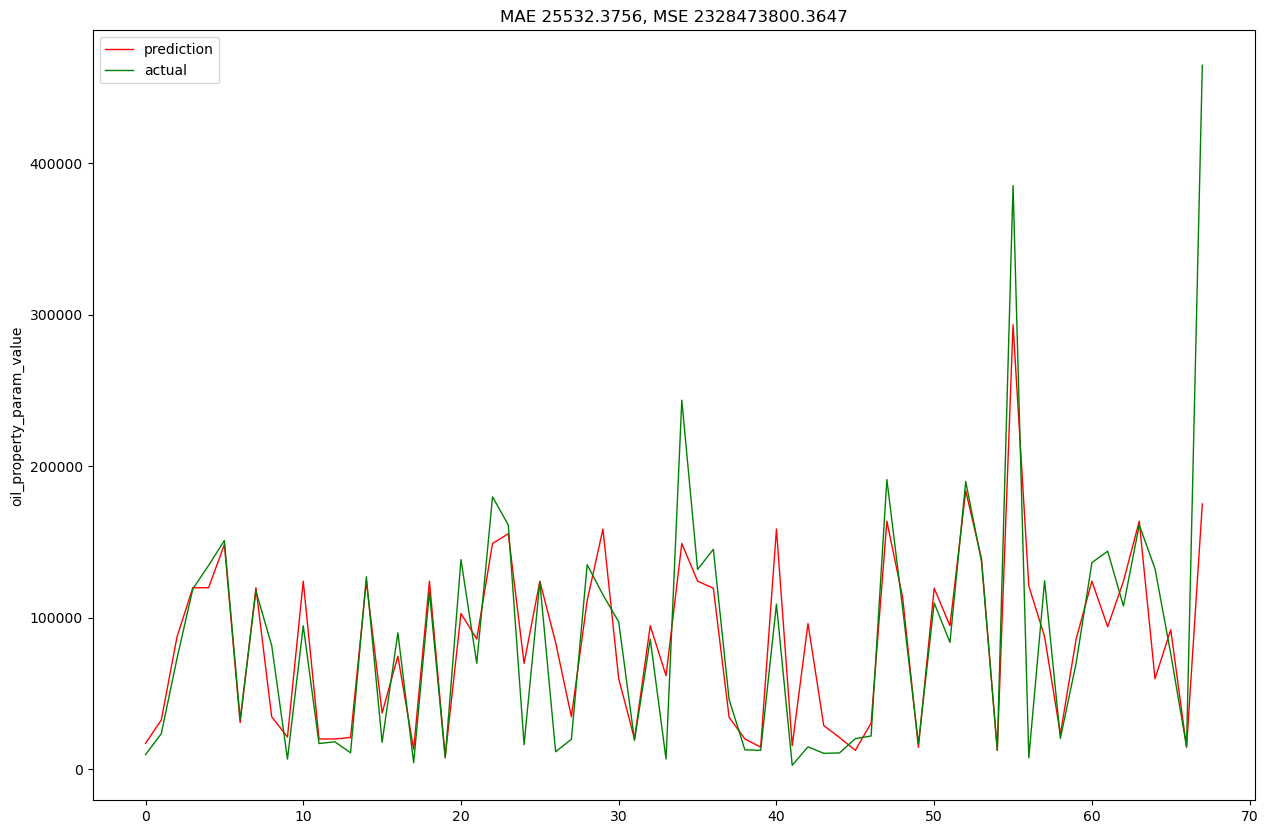

MAE score: 25532.3756
MSE score: 2328473800.3647
XGBRegressor
[0]	validation_0-rmse:0.98447
[1]	validation_0-rmse:0.93022


/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[2]	validation_0-rmse:0.88083
[3]	validation_0-rmse:0.83953
[4]	validation_0-rmse:0.78713
[5]	validation_0-rmse:0.75477
[6]	validation_0-rmse:0.71262
[7]	validation_0-rmse:0.69520
[8]	validation_0-rmse:0.66909
[9]	validation_0-rmse:0.64558
[10]	validation_0-rmse:0.62489
[11]	validation_0-rmse:0.60694
[12]	validation_0-rmse:0.59287
[13]	validation_0-rmse:0.57993
[14]	validation_0-rmse:0.56824
[15]	validation_0-rmse:0.55831
[16]	validation_0-rmse:0.54878
[17]	validation_0-rmse:0.54036
[18]	validation_0-rmse:0.53327
[19]	validation_0-rmse:0.52673
[20]	validation_0-rmse:0.52166
[21]	validation_0-rmse:0.51620
[22]	validation_0-rmse:0.51217
[23]	validation_0-rmse:0.50844
[24]	validation_0-rmse:0.50535
[25]	validation_0-rmse:0.50142
[26]	validation_0-rmse:0.49853
[27]	validation_0-rmse:0.49702
[28]	validation_0-rmse:0.49435
[29]	validation_0-rmse:0.49212
[30]	validation_0-rmse:0.48999
[31]	validation_0-rmse:0.48868
[32]	validation_0-rmse:0.48823
[33]	validation_0-rmse:0.48646
[34]	validation_

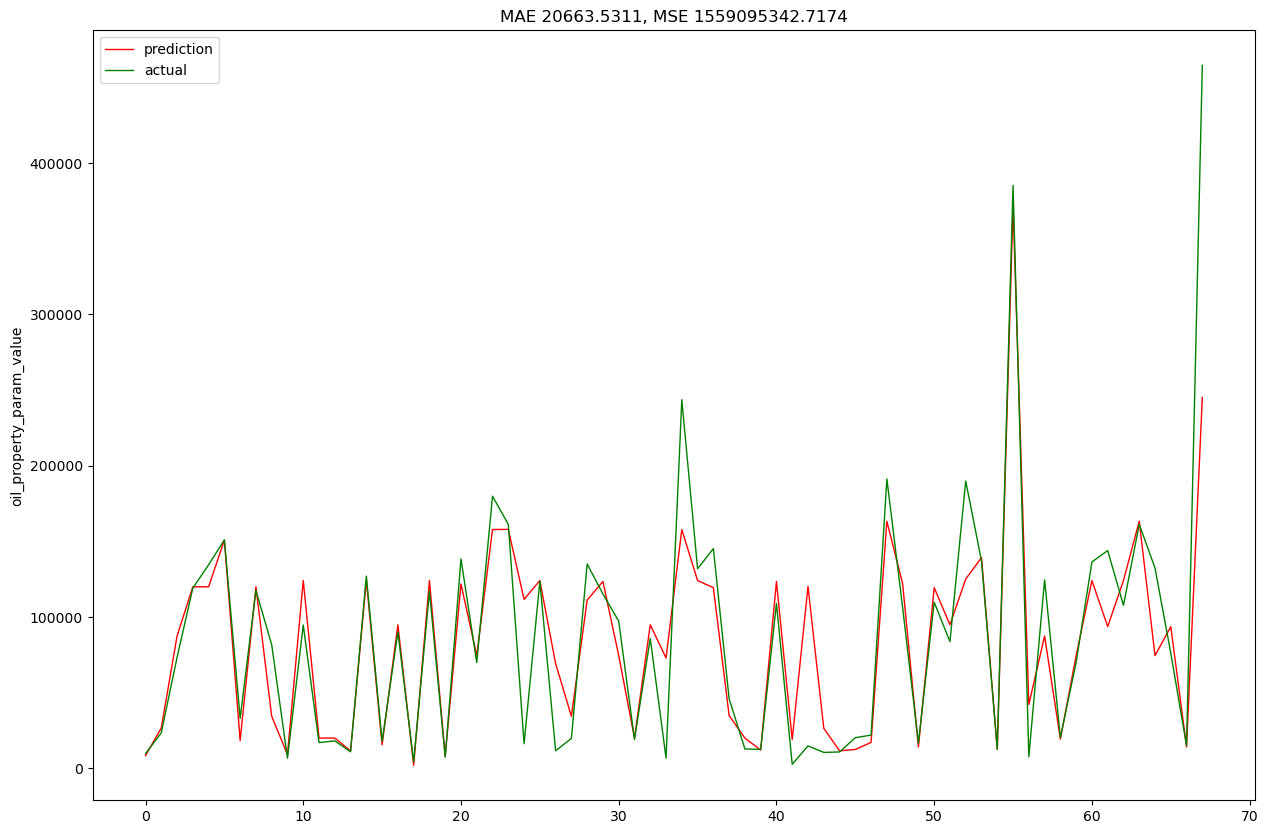

MAE score: 20663.5311
MSE score: 1559095342.7174
LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23008
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 384
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

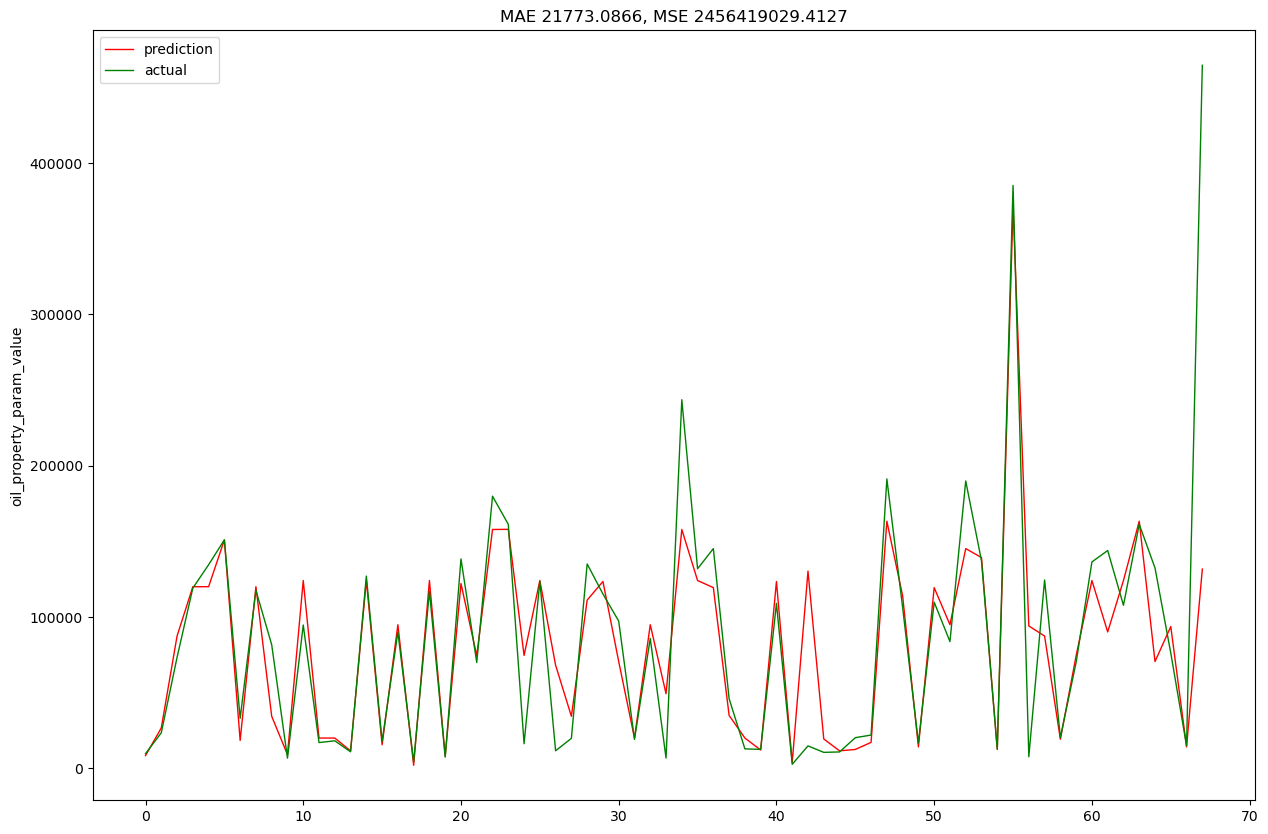

MAE score: 21773.0866
MSE score: 2456419029.4127
GradientBoostingRegressor


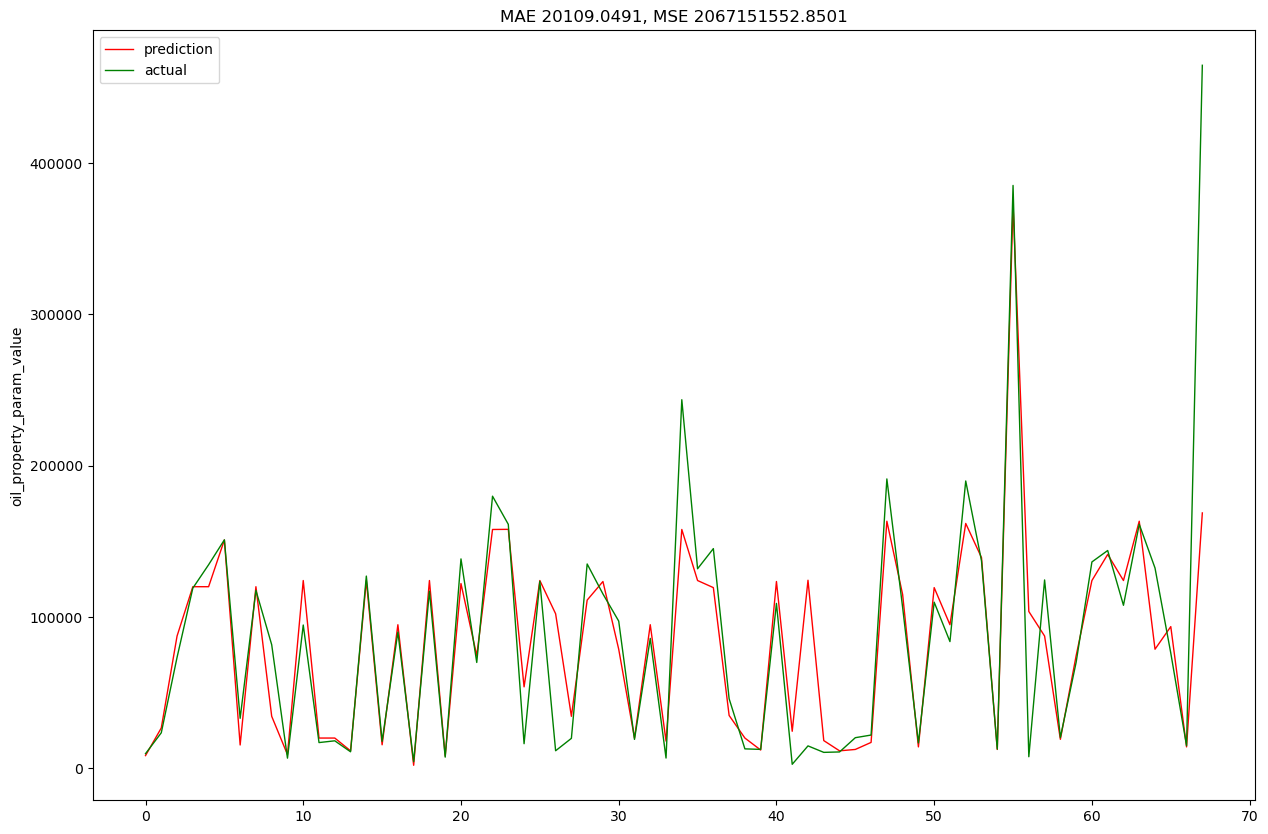

MAE score: 20109.0491
MSE score: 2067151552.8501
SVR


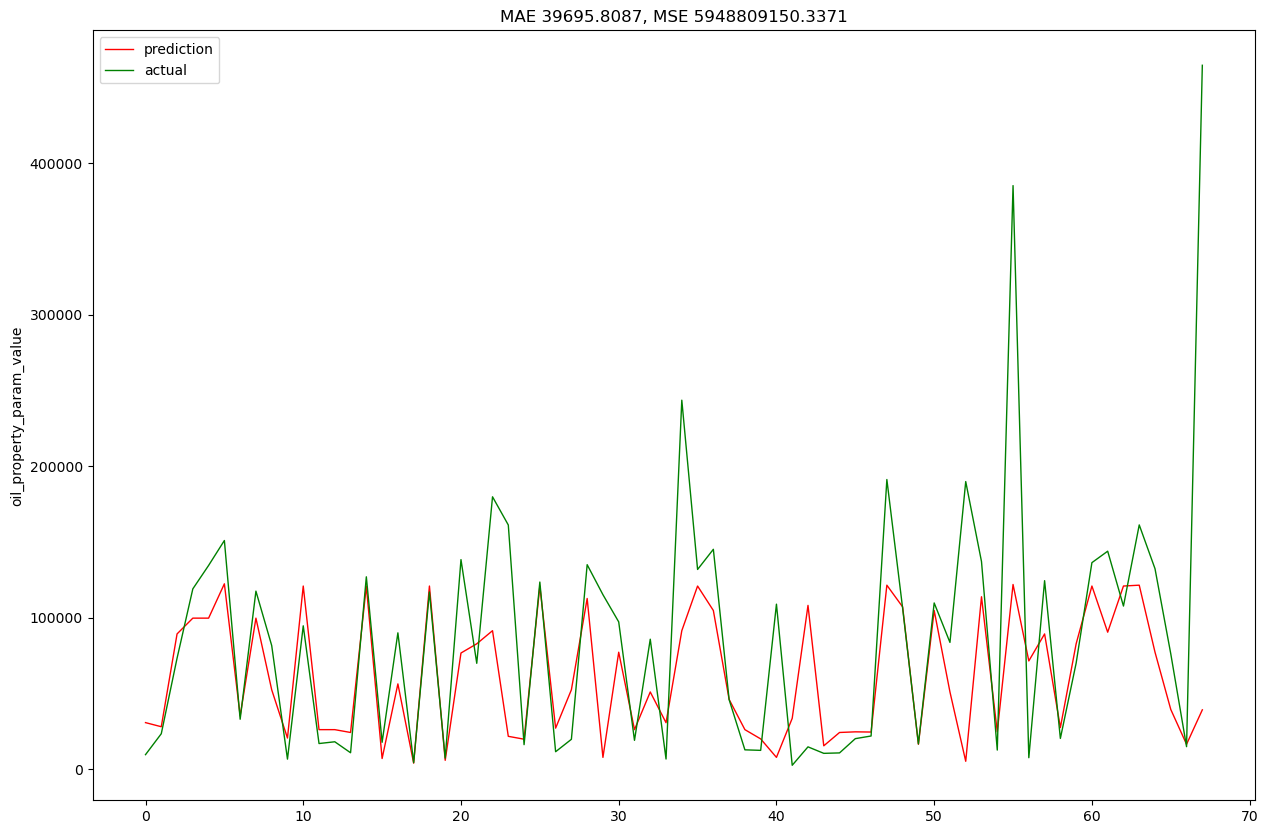

MAE score: 39695.8087
MSE score: 5948809150.3371


In [62]:

regression_models = SimpleRegressions(X, y)
regression_models.fit_and_evaluate()



Epoch 1/400
4/4 [==============================] - 1s 81ms/step - loss: 0.0144 - mean_absolute_error: 0.0780 - val_loss: 0.0042 - val_mean_absolute_error: 0.0501 - lr: 0.0010
Epoch 2/400
4/4 [==============================] - 0s 23ms/step - loss: 0.0125 - mean_absolute_error: 0.0609 - val_loss: 0.0049 - val_mean_absolute_error: 0.0585 - lr: 0.0010
Epoch 3/400
4/4 [==============================] - 0s 20ms/step - loss: 0.0131 - mean_absolute_error: 0.0758 - val_loss: 0.0054 - val_mean_absolute_error: 0.0628 - lr: 0.0010
Epoch 4/400
4/4 [==============================] - 0s 20ms/step - loss: 0.0102 - mean_absolute_error: 0.0575 - val_loss: 0.0044 - val_mean_absolute_error: 0.0524 - lr: 0.0010
Epoch 5/400
4/4 [==============================] - 0s 26ms/step - loss: 0.0115 - mean_absolute_error: 0.0591 - val_loss: 0.0040 - val_mean_absolute_error: 0.0517 - lr: 0.0010
Epoch 6/400
4/4 [==============================] - 0s 25ms/step - loss: 0.0102 - mean_absolute_error: 0.0574 - val_loss: 0.00

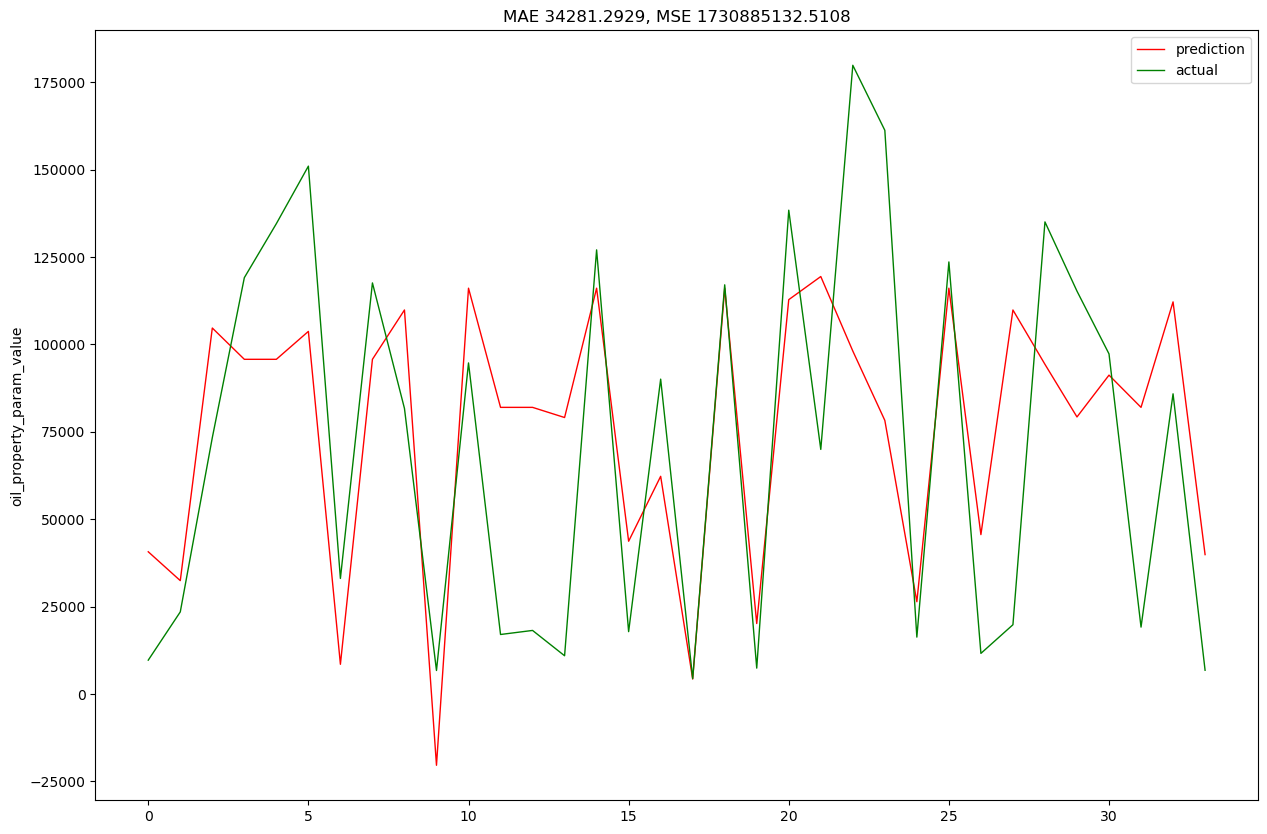

MAE score: 34281.2929
MSE score: 1730885132.5108


: 

In [70]:

nn_model = SmallNN(X, y)
nn_model.fit_and_evaluate()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/20
5/5 [==============================] - 22s 3s/step - loss: 1.0072 - val_loss: 1.0100 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 1.0061 - val_loss: 0.9998 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 1.0023 - val_loss: 0.9993 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 1.0019 - val_loss: 0.9967 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 12s 3s/step - loss: 0.9947 - val_loss: 0.9970 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 16s 3s/step - loss: 1.0036 - val_loss: 0.9940 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 12s 2s/step - loss: 0.9941 - val_loss: 0.9839 - lr: 0.0010
Epoch 8/20
5/5 [==============================] - 12s 2s/step - loss: 0.9836 - val_loss: 1.1705 - lr: 0.0010
Epoch 9/20
5/5 [==============================] - 10s 2s/step - loss: 1.0401 - val_loss: 0.9843 - lr: 0.0010
Epoch 10/20
5/5 [==

AttributeError: 'LstmRegressor' object has no attribute 'metrics'

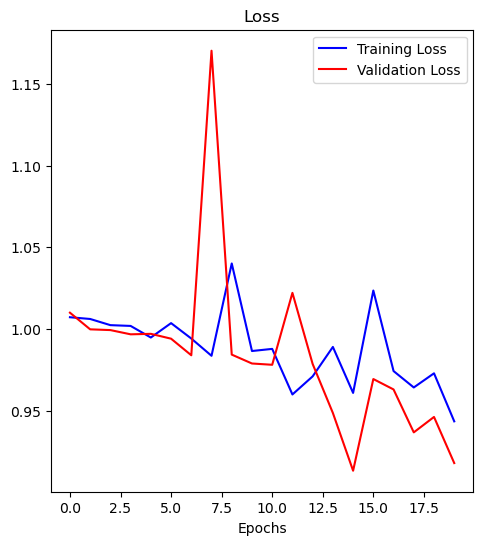

In [38]:
scaler_ = StandardScaler() # RobustScaler
regressor = LstmRegressor(units=50, dropout_rate=0.2, optimizer='rmsprop', epochs=20, 
                          batch_size=64, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

model, _ = regressor.fit(X_train, y_train, X_test, y_test)

2/2 [==============================] - 0s 10ms/step - loss: 2158426880.0000 - mean_absolute_error: 38744.6484
